https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d

In [1]:
%pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [38]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from lifelines import (
    CoxPHFitter,
    ExponentialFitter,
    KaplanMeierFitter,
    LogLogisticFitter,
    LogNormalFitter,
    NelsonAalenFitter,
    WeibullAFTFitter,
    WeibullFitter,
)
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.utils import median_survival_times

In [3]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Lung data")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Lung data


In [5]:
data = pd.read_csv(os.path.join(path_folder, "data/lung.csv"), sep=",")
print(data.shape)
data.head()

(228, 10)


,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


In [6]:
data = data[["time", "status", "age", "sex", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss"]]
data["status"] = data["status"] - 1
data["sex"] = data["sex"] - 1
data.head()


,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,306,0,74,0,1.0,90.0,100.0,1175.0,NaN
1,455,0,68,0,0.0,90.0,90.0,1225.0,15.0
2,1010,-1,56,0,0.0,90.0,90.0,NaN,15.0
3,210,0,57,0,1.0,90.0,60.0,1150.0,11.0
4,883,0,60,0,0.0,100.0,90.0,NaN,0.0


In [7]:
data.dtypes

time           int64
status         int64
age            int64
sex            int64
ph.ecog      float64
ph.karno     float64
pat.karno    float64
meal.cal     float64
wt.loss      float64
dtype: object

In [8]:
data.isnull().sum()

time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64

In [9]:
data["ph.karno"].fillna(data["ph.karno"].mean(), inplace=True)
data["pat.karno"].fillna(data["pat.karno"].mean(), inplace=True)
data["meal.cal"].fillna(data["meal.cal"].mean(), inplace=True)
data["wt.loss"].fillna(data["wt.loss"].mean(), inplace=True)
data.dropna(inplace=True)
data["ph.ecog"] = data["ph.ecog"].astype("int64")


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_8637/1125125482.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["ph.karno"].fillna(data["ph.karno"].mean(), inplace=True)
/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_8637/1125125482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

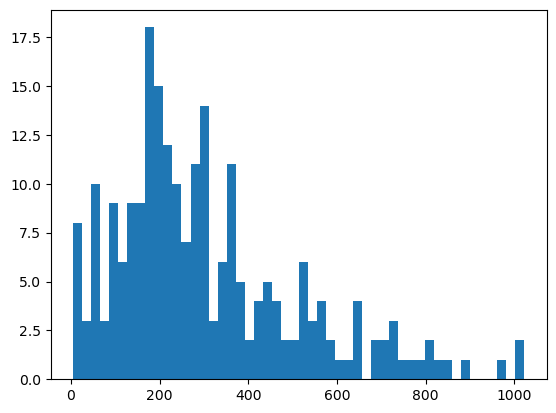

In [10]:
T = data["time"]
E = data["status"]
plt.hist(T, bins = 50)
plt.show()

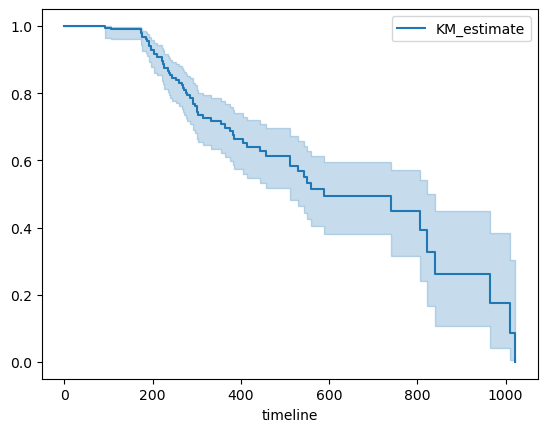

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)
kmf.plot_survival_function()
plt.show()


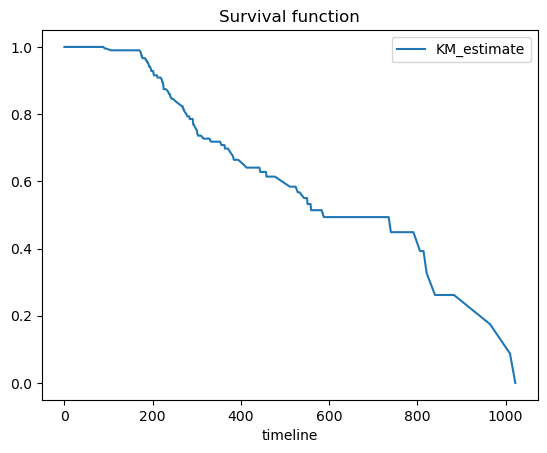

In [15]:
kmf.survival_function_.plot()
plt.title("Survival function")
plt.show()


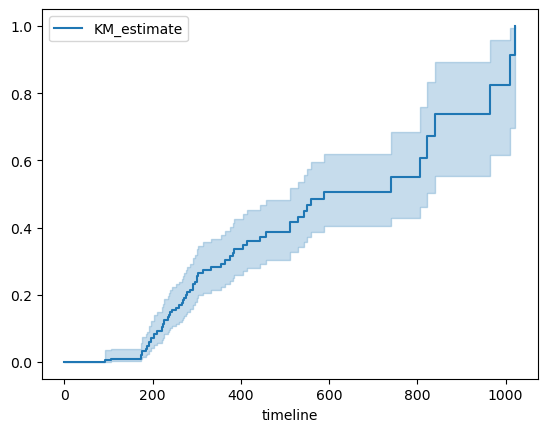

In [16]:
kmf.plot_cumulative_density()
plt.show()

In [19]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)


588.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   511.0                   821.0


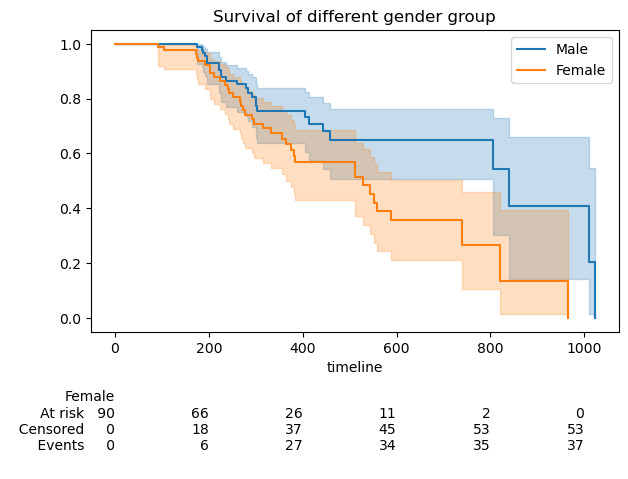

In [21]:
ax = plt.subplot(111)
m = data["sex"] == 0
kmf.fit(durations=T[m], event_observed=E[m], label="Male")
kmf.plot_survival_function(ax=ax)
kmf.fit(T[~m], event_observed=E[~m], label="Female")
kmf.plot_survival_function(ax=ax, at_risk_counts=True)
plt.title("Survival of different gender group")
plt.show()

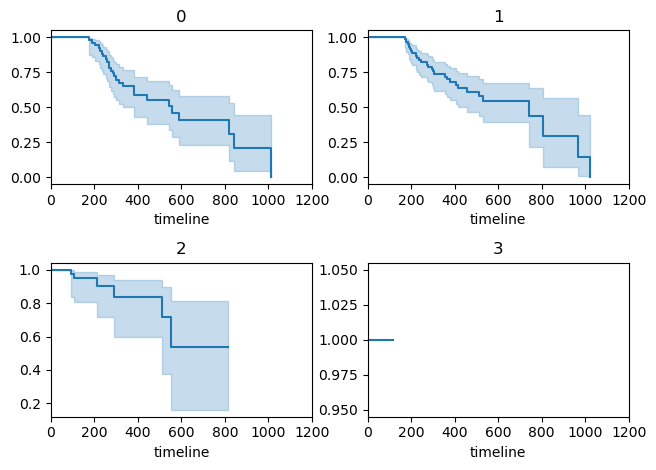

In [22]:
ecog_types = data.sort_values(by=["ph.ecog"])["ph.ecog"].unique()
for i, ecog_types in enumerate(ecog_types):
    ax = plt.subplot(2, 2, i + 1)
    ix = data["ph.ecog"] == ecog_types
    kmf.fit(T[ix], E[ix], label=ecog_types)
    kmf.plot_survival_function(ax=ax, legend=False)
    plt.title(ecog_types)
    plt.xlim(0, 1200)
plt.tight_layout()


In [23]:
data["ph.ecog"].value_counts()


ph.ecog
1    113
0     63
2     50
3      1
Name: count, dtype: int64

In [24]:
data = data[data["ph.ecog"] != 3]
data.shape

(226, 9)

In [25]:
dummies_ecog = pd.get_dummies(data["ph.ecog"], prefix="ecog")
dummies_ecog.head(4)


,ecog_0,ecog_1,ecog_2
0,False,True,False
1,True,False,False
2,True,False,False
3,False,True,False


In [26]:
dummies_ecog = dummies_ecog[["ecog_1", "ecog_2"]]
data = pd.concat([data, dummies_ecog], axis=1)
data = data.drop("ph.ecog", axis=1)
data.head()


,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
0,306,0,74,0,90.0,100.0,1175.000000,9.831776,True,False
1,455,0,68,0,90.0,90.0,1225.000000,15.000000,False,False
2,1010,-1,56,0,90.0,90.0,928.779006,15.000000,False,False
3,210,0,57,0,90.0,60.0,1150.000000,11.000000,True,False
4,883,0,60,0,100.0,90.0,928.779006,0.000000,False,False


In [28]:
cph = CoxPHFitter()
cph.fit(data, duration_col="time", event_col="status")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 226 total observations, 163 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 226
number of events observed = 63
   partial log-likelihood = -257.92
         time fit was run = 2024-07-18 12:55:02 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.02      0.98      0.02           -0.05            0.01                0.95                1.01
sex        0.61      1.83      0.27            0.08            1.14                1.08                3.11
ph.karno   0.02      1.02      0.02           -0.02            0.06                0.98                1.06
pat.karno -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
meal.cal  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss   -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
ecog_1     0.05      1.06      0.37           -0.67            0.77                0.51                2.17
ecog_2     0.05      1.05      0.72           -1.36            1.46                0.26                4.30

           cmp to     z    p  -log2(p)
covariate                             
age          0.00 -1.33 0.18      2.46
sex          0.00  2.24 0.03      5.32
ph.karno     0.00  1.03 0.30      1.73
pat.karno    0.00 -0.26 0.79      0.34
meal.cal     0.00 -0.52 0.60      0.73
wt.loss      0.00 -0.17 0.87      0.21
ecog_1       0.00  0.15 0.88      0.18
ecog_2       0.00  0.07 0.94      0.08
---
Concordance = 0.58
Partial AIC = 531.85
log-likelihood ratio test = 11.60 on 8 df
-log2(p) of ll-ratio test = 2.56

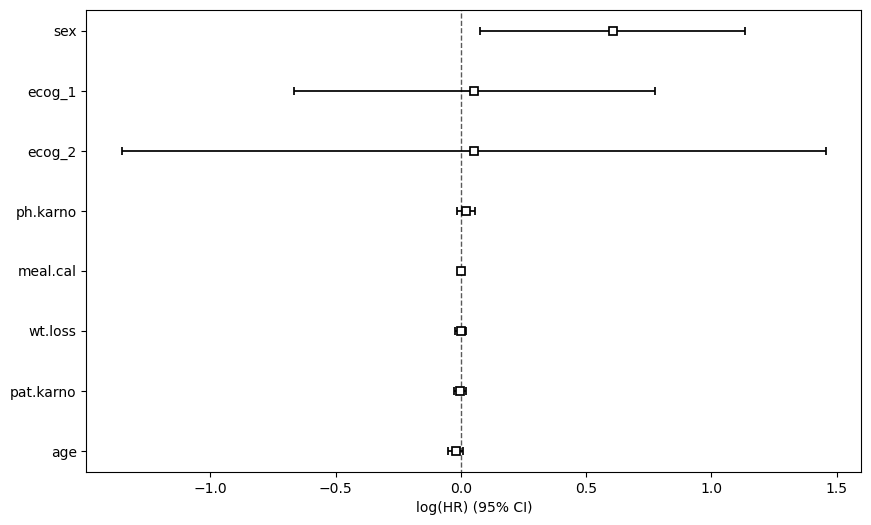

In [29]:
plt.subplots(figsize = (10, 6))
cph.plot()
plt.show()

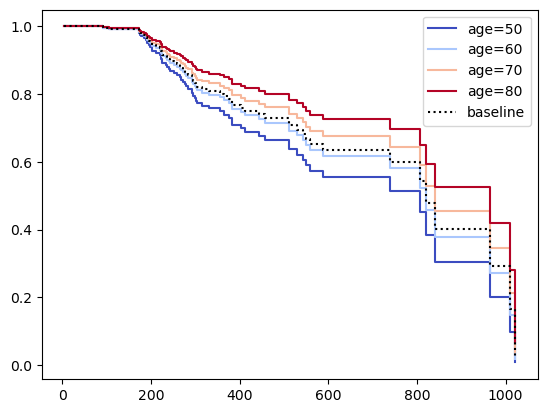

In [31]:
cph.plot_partial_effects_on_outcome(covariates="age", values=[50, 60, 70, 80], cmap="coolwarm")
plt.show()

In [32]:
cph.check_assumptions(data, p_value_threshold=0.05)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 226 total observations, 163 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
age       km              0.41 0.52      0.94
          rank            0.66 0.42      1.26
ecog_1    km              0.00 0.99      0.01
          rank            0.11 0.74      0.44
ecog_2    km              0.03 0.85      0.23
          rank            0.06 0.81      0.30
meal.cal  km              1.18 0.28      1.85
          rank            3.77 0.05      4.26
pat.karno km              0.06 0.81      0.31
          rank            0.00 0.98      0.04
ph.karno  km              0.80 0.37      1.43
          rank            0.47 0.50      1.01
sex       km              0.91 0.34      1.55
          rank            0.61 0.43      1.20
wt.loss   km              1.73 0.19      2.41
          rank            2.76 0.10      3.37



1. Variable 'meal.cal' failed the non-proportional test: p-value is 0.0522.

   Advice 1: the functional form of the variable 'meal.cal' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'meal.cal' using pd.cut, and then specify it in
`strata=['meal.cal', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#

[]

In [35]:
results = proportional_hazard_test(cph, data, time_transform="rank")
results.print_summary(decimals=3, model="untransformed variables")


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 226 total observations, 163 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
age                  0.66 0.42      1.26
ecog_1               0.11 0.74      0.44
ecog_2               0.06 0.81      0.30
meal.cal             3.77 0.05      4.26
pat.karno            0.00 0.98      0.04
ph.karno             0.47 0.50      1.01
sex                  0.61 0.43      1.20
wt.loss              2.76 0.10      3.37

In [37]:
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations=data["time"], event_observed=data["status"])
# Print AIC
print("The AIC value for", model.__class__.__name__, "is", model.AIC_)


The AIC value for LogLogisticFitter is 967.5671666134224


In [39]:
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data, duration_col="time", event_col="status")
weibull_aft.print_summary(3)


<lifelines.WeibullAFTFitter: fitted with 226 total observations, 163 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 226
number of events observed = 63
           log-likelihood = -478.562
         time fit was run = 2024-07-18 12:58:06 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ age        0.009     1.009     0.008          -0.006           0.024               0.994               1.024
        ecog_1     0.096     1.101     0.179          -0.255           0.447               0.775               1.564
        ecog_2     0.200     1.222     0.345          -0.475           0.876               0.622               2.400
        meal.cal   0.000     1.000     0.000          -0.000           0.001               1.000               1.001
        pat.karno -0.000     1.000     0.006          -0.013           0.012               0.987               1.012
        ph.karno  -0.003     0.997     0.008          -0.019           0.014               0.981               1.014
        sex       -0.268     0.765     0.134          -0.530          -0.006               0.588               0.994
        wt.loss    0.001     1.001     0.006          -0.010           0.012               0.990               1.013
        Intercept  6.116   453.004     1.050           4.057           8.175              57.809            3549.839
rho_    Intercept  0.694     2.001     0.092           0.513           0.874               1.671               2.396

                   cmp to      z       p  -log2(p)
param   covariate                                 
lambda_ age         0.000  1.152   0.249     2.004
        ecog_1      0.000  0.537   0.592     0.757
        ecog_2      0.000  0.581   0.561     0.834
        meal.cal    0.000  1.002   0.316     1.660
        pat.karno   0.000 -0.073   0.942     0.086
        ph.karno    0.000 -0.314   0.753     0.409
        sex         0.000 -2.008   0.045     4.485
        wt.loss     0.000  0.253   0.800     0.322
        Intercept   0.000  5.822 <0.0005    27.361
rho_    Intercept   0.000  7.538 <0.0005    44.247
---
Concordance = 0.569
AIC = 977.124
log-likelihood ratio test = 9.864 on 8 df
-log2(p) of ll-ratio test = 1.864

In [40]:
print(weibull_aft.median_survival_time_)
print(weibull_aft.mean_survival_time_)

709.4987451762623
755.1715757763873


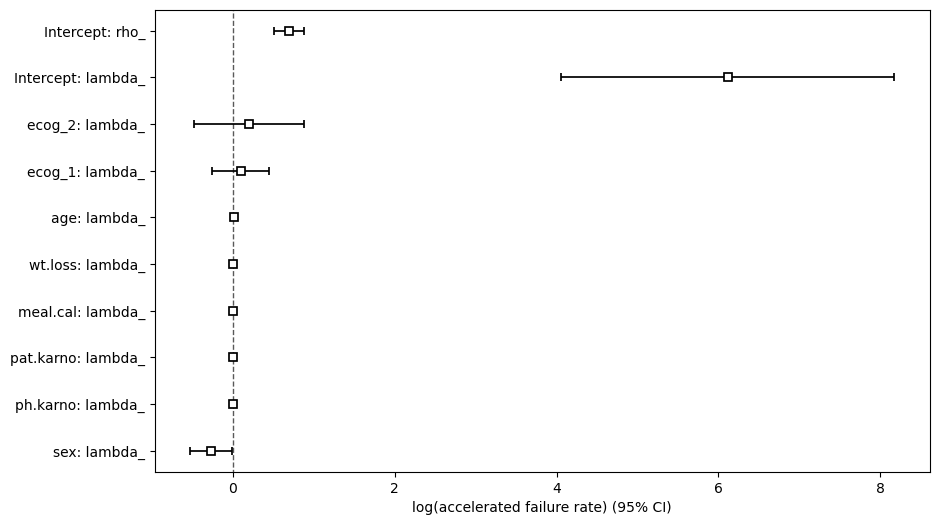

In [41]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot()
plt.show()

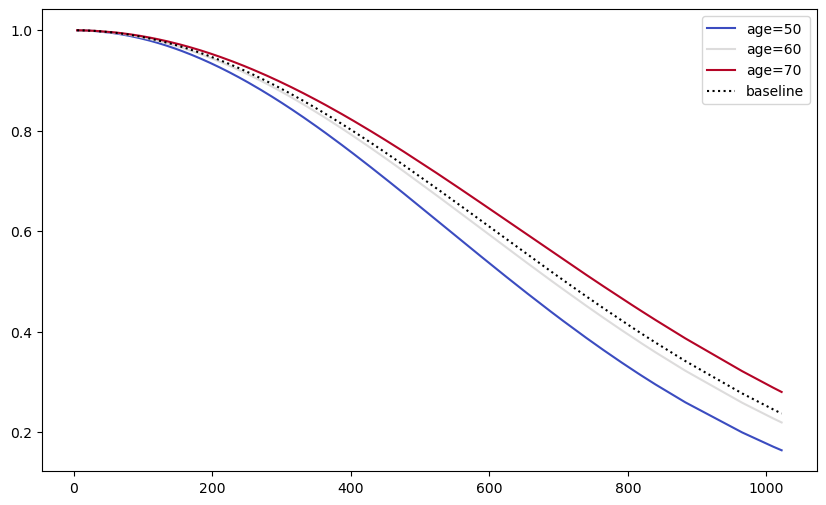

In [42]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot_partial_effects_on_outcome("age", range(50, 80, 10), cmap="coolwarm")
plt.show()
